In [31]:
import pandas as pd
import numpy as np
import pickle
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from sklearn.preprocessing import LabelBinarizer
import sklearn.datasets as skds
from pathlib import Path
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
#Following https://towardsdatascience.com/machine-learning-multiclass-classification-with-imbalanced-data-set-29f6a177c1a 
np.random.seed(1237)

In [3]:
labels = np.load("labels.npy")
data = np.load("data.npy")

In [63]:
# 5 groups
num_labels = 5
vocab_size = 10
batch_size = 100
num_epochs = 5

# lets take 80% data as training and remaining 20% for test.
train_size = int(len(labels) * .8)
print(train_size)
x_train = data[:train_size]
x_test = data[train_size:]

encoder = LabelBinarizer()
encoder.fit(labels[:train_size])
y_train_labels = labels[:train_size]
y_test_labels = labels[train_size:]
y_train = encoder.transform(y_train_labels)
y_test = encoder.transform(y_test_labels)

14527


In [26]:
#let us build a basic model
model = Sequential()
model.add(Dense(512, input_shape=(vocab_size,)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               5632      
_________________________________________________________________
activation_6 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_7 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                

Build model...


NotImplementedError: Cannot convert a symbolic Tensor (gru/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [65]:
num_epochs =30
batch_size = 128

from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced' ,np.unique(y_train_labels) ,y_train_labels)
weight = {i : class_weight[i] for i in range(5)}

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=2,
                    validation_split=0.2)

Epoch 1/30
91/91 - 1s - loss: 0.6264 - accuracy: 0.7974 - val_loss: 0.6564 - val_accuracy: 0.7894
Epoch 2/30
91/91 - 1s - loss: 0.6234 - accuracy: 0.7975 - val_loss: 0.6568 - val_accuracy: 0.7887
Epoch 3/30
91/91 - 1s - loss: 0.6239 - accuracy: 0.7977 - val_loss: 0.6564 - val_accuracy: 0.7901
Epoch 4/30
91/91 - 1s - loss: 0.6208 - accuracy: 0.7978 - val_loss: 0.6569 - val_accuracy: 0.7894
Epoch 5/30
91/91 - 1s - loss: 0.6190 - accuracy: 0.7995 - val_loss: 0.6582 - val_accuracy: 0.7897
Epoch 6/30
91/91 - 1s - loss: 0.6211 - accuracy: 0.7977 - val_loss: 0.6588 - val_accuracy: 0.7901
Epoch 7/30
91/91 - 1s - loss: 0.6215 - accuracy: 0.7976 - val_loss: 0.6599 - val_accuracy: 0.7908
Epoch 8/30
91/91 - 1s - loss: 0.6182 - accuracy: 0.7985 - val_loss: 0.6624 - val_accuracy: 0.7901
Epoch 9/30
91/91 - 1s - loss: 0.6200 - accuracy: 0.7974 - val_loss: 0.6595 - val_accuracy: 0.7901
Epoch 10/30
91/91 - 1s - loss: 0.6170 - accuracy: 0.7987 - val_loss: 0.6637 - val_accuracy: 0.7894
Epoch 11/30
91/91 -

(3632, 5) (3632, 5)


<AxesSubplot:>

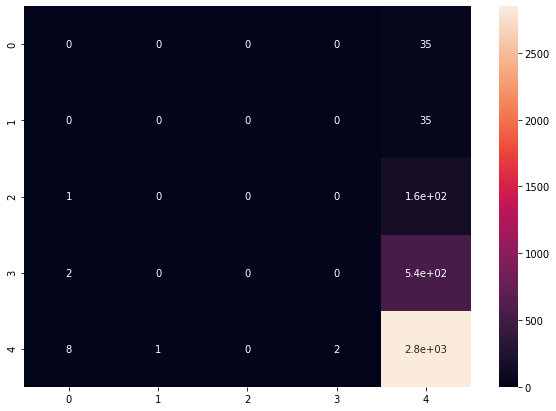

In [66]:
y_pred = model.predict(x_test);
print(y_pred.shape, y_test.shape)
cnf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plt.figure(figsize = (10,7))
sn.heatmap(cnf_matrix, annot=True)

In [53]:
y_test_labels = np.argmax(y_test, axis =1)
y_train_labels = np.argmax(y_train, axis =1)
y_test_labels
np.unique(y_train_labels)

array([0, 1, 2, 3, 4], dtype=int64)

In [57]:
#Let us try some sampling technique to remove class imbalance
from imblearn.over_sampling import SMOTE
#Over-sampling: SMOTE
#SMOTE (Synthetic Minority Oversampling TEchnique) consists of synthesizing elements for the minority class, 
#based on those that already exist. It works randomly picking a point from the minority class and computing 
#the k-nearest neighbors for this point.The synthetic points are added between the chosen point and its neighbors.
#We'll use ratio='minority' to resample the minority class.
smote = SMOTE('minority')
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced' ,np.unique(y_train_labels) ,y_train_labels)
weight = {i : class_weight[i] for i in range(5)}
X_sm, y_sm = smote.fit_resample(x_train, y_train)
print(X_sm.shape, y_sm.shape)

(25985, 10) (25985, 5)


c:\users\parke\onedrive\documents\github\citrusenv\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4], y=[4 4 4 ... 4 4 4] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
c:\users\parke\onedrive\documents\github\citrusenv\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [67]:

history = model.fit(X_sm, y_sm,
                    batch_size=batch_size,
                    epochs=100,
                    verbose=2,
                    class_weight=weight,
                    validation_split=0.2)


Epoch 1/100
163/163 - 1s - loss: 1.4484 - accuracy: 0.4809 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 2/100
163/163 - 5s - loss: 1.0269 - accuracy: 0.4817 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 3/100
163/163 - 1s - loss: 0.9494 - accuracy: 0.4975 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 4/100
163/163 - 1s - loss: 0.9249 - accuracy: 0.4996 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 5/100
163/163 - 1s - loss: 0.8908 - accuracy: 0.4961 - val_loss: 0.0047 - val_accuracy: 1.0000
Epoch 6/100
163/163 - 1s - loss: 0.8760 - accuracy: 0.5082 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 7/100
163/163 - 1s - loss: 0.8789 - accuracy: 0.5043 - val_loss: 0.0037 - val_accuracy: 1.0000
Epoch 8/100
163/163 - 1s - loss: 0.8716 - accuracy: 0.5042 - val_loss: 8.8080e-04 - val_accuracy: 1.0000
Epoch 9/100
163/163 - 1s - loss: 0.8364 - accuracy: 0.5087 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 10/100
163/163 - 1s - loss: 0.8604 - accuracy: 0.5029 - val_loss: 0.0024 - val_ac

Epoch 81/100
163/163 - 1s - loss: 0.6311 - accuracy: 0.5503 - val_loss: 8.7436e-04 - val_accuracy: 1.0000
Epoch 82/100
163/163 - 1s - loss: 0.6374 - accuracy: 0.5445 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 83/100
163/163 - 1s - loss: 0.6448 - accuracy: 0.5436 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 84/100
163/163 - 1s - loss: 0.6426 - accuracy: 0.5512 - val_loss: 7.6358e-04 - val_accuracy: 1.0000
Epoch 85/100
163/163 - 1s - loss: 0.6192 - accuracy: 0.5508 - val_loss: 4.0260e-04 - val_accuracy: 1.0000
Epoch 86/100
163/163 - 1s - loss: 0.6308 - accuracy: 0.5516 - val_loss: 9.5674e-04 - val_accuracy: 1.0000
Epoch 87/100
163/163 - 1s - loss: 0.6321 - accuracy: 0.5584 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 88/100
163/163 - 1s - loss: 0.6302 - accuracy: 0.5490 - val_loss: 8.0358e-04 - val_accuracy: 1.0000
Epoch 89/100
163/163 - 1s - loss: 0.6201 - accuracy: 0.5514 - val_loss: 5.5356e-04 - val_accuracy: 1.0000
Epoch 90/100
163/163 - 1s - loss: 0.6157 - accuracy: 0.550

(3632, 5) (3632, 5)


<AxesSubplot:>

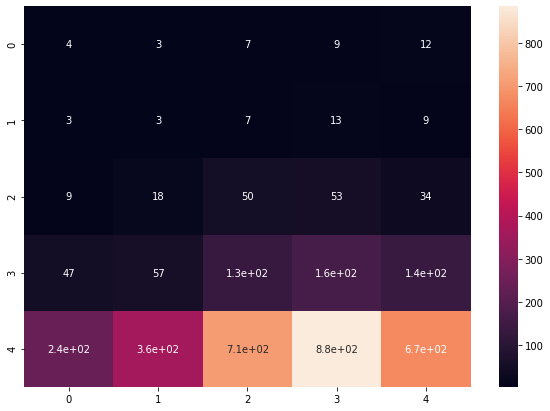

In [68]:
y_pred = model.predict(x_test);
print(y_pred.shape, y_test.shape)
cnf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plt.figure(figsize = (10,7))
sn.heatmap(cnf_matrix, annot=True)
